In [43]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import torch
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from time import time
from copy import deepcopy

import src.training as training
import src.models as models

from importlib import reload
reload(training)
reload(models)

device = 'cuda'

In [44]:
batch_size = 5
n_samples = 1000
n_tasks = 20

# Check for existing metalearner class in current namespace
if 'metalearner' in locals():
   pass
else:

    model = models.FastWeightCNN(
        input_size=10,
        latent_dim=(16,16),
        output_size=750,
        dropout_rate=0.2
    )

    # Create a new MetaLearner instance
    metalearner = training.MetaLearner(
        model=model,
        outer_lr=0.01,
        inner_lr=0.001,
        loss_fn=torch.nn.MSELoss,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        seed=14,
        device=device
    )

# Load metaleraner weights
metalearner.model.load_state_dict(
    torch.load(
        '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(batch_size, n_samples, n_tasks)
    )
)

<All keys matched successfully>

In [45]:
pretrain_file = 'data/42_dndz_nsamples=30000.h5'

n_train = 20000
singletask_weights = '{}samples_single_task_emulator_weights.pt'.format(n_train)

if os.path.exists(singletask_weights): # Check for existing trained weights
    pretrain_model = models.FastWeightCNN(
        input_size=10,
        latent_dim=(16,16),
        output_size=750,
        dropout_rate=0.2
    )
    # load weights to model
    pretrain_model.load_state_dict(torch.load(singletask_weights))
else:
    # Load pretraining data for standard training emulator
    train_data, _, X_val, y_val, _, _ = training.load_train_test_val(
        filepath=pretrain_file, n_train=n_train, n_val=4000, n_test=None, seed=14,
        device=device
    )
    # Pretrain an emulator in the standard way
    train_loader = DataLoader(train_data, batch_size=5000, shuffle=False)
    print('Pre-training emulator with {} samples...'.format(len(train_data)))
    pretrain_model, pretrain_time, _, _ = training.train_standard_emulator(train_loader, X_val, y_val, device=device)
    print('Pre-training time:', pretrain_time)

    # Save trained weights
    torch.save(
        pretrain_model.state_dict(),
        '{}samples_single_task_emulator_weights.pt'.format(n_train)
        )
    
original_model = deepcopy(pretrain_model.state_dict())

- Instead of running first an MCMC do a Fisher forecast
- Generate from that Sobol seq and use that as training sample

In [ ]:
filepath = 'mcmc/76walkers_chain_outputs_CCL.h5'
with h5.File(filepath, 'r') as f:
    mcmc = f['mcmc']
    log_probs = mcmc['log_prob'][:].reshape(-1)
    pos = mcmc['chain'][0]
    X = mcmc['chain'][:].reshape(-1, 10)
    y = mcmc['blobs'][:].reshape(-1)
    y = np.array([arr[0] for arr in y[:]])
    print(y.shape)
    print(X.shape)
    print(log_probs.shape)

# Compute
param_meds = np.median(X, axis=0)
print(param_meds)
below_meds = np.all(X < param_meds, axis=1)
# print number of samples below median for each parameter
print(np.sum(below_meds, axis=0))
log_probs_below_med = log_probs[np.all(X < param_meds, axis=1)]
print(below_meds.shape)

quantile = 0.1 
cutoff = np.quantile(log_probs, quantile)
print(cutoff)

lower_tail = below_meds[log_probs_below_med < cutoff]
print(lower_tail.shape)


(1064000, 750)
(1064000, 10)
(1064000,)
[ 2.65359498e-01  4.98845316e-02  7.04929092e-01  8.28907965e-01
  9.49512983e-01  6.07403881e-06  4.24450287e-05 -4.90761543e-06
  2.80316795e-05 -4.27605354e-05]
1
(1064000,)
-4.819892742255686


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1064000 but corresponding boolean dimension is 1

In [47]:
# # Reformat and save as new file
# filepath = 'data/samples_from_chain_{}.h5'.format(n_samples)
# with h5.File(filepath, 'w') as f:
#     f.create_dataset('hypercube', data=X)
#     f.create_dataset('c_ells', data=y)

In [70]:
n_fine = 76
sample_indices = np.random.choice(tail_indices, n_fine, replace=False)

# Take log of y
y_log = np.log(y)

#Train on the tail of the chain
X_train = X[sample_indices]
y_train = y_log[sample_indices]
print(X_train[0])

test_indices = np.delete(np.arange(len(X)), sample_indices)
test_indices = np.random.choice(test_indices, 50000, replace=False)
X_test = X[test_indices]
y_test = y_log[test_indices]

# Split into test training and validation sets
#X_train, X_test, y_train, y_test = train_test_split(X, y_log, train_size=n_fine, random_state=363)

# Train on first steps
# X_train = X[:n_fine]
# y_train = y_log[:n_fine]
# X_test = X[n_fine:]
# y_test = y_log[n_fine:]

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
    
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=2048, shuffle=False)

# test on the test set in batches
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

[ 2.66729961e-01  4.53700812e-02  6.61576701e-01  8.10322590e-01
  9.57981151e-01  1.42132978e-05  6.20995517e-05 -3.29424125e-05
 -4.09894676e-05  2.67899769e-05]
X_train shape: torch.Size([76, 10])
y_train shape: torch.Size([76, 750])
X_test shape: torch.Size([50000, 10])
y_test shape: torch.Size([50000, 750])


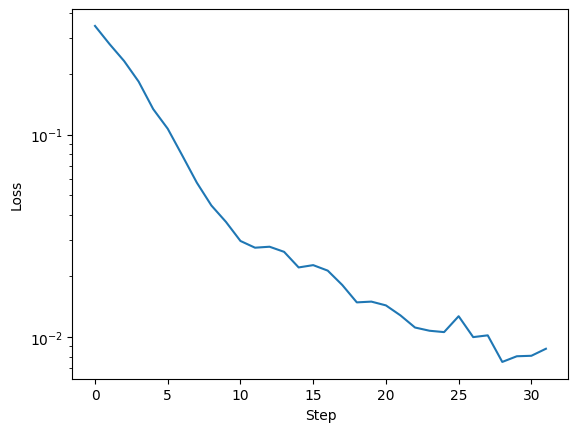

In [71]:
# Perform finetuning
task_weights, losses = metalearner.finetune(X_train, y_train, adapt_steps=32, use_new_adam=True)

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

In [72]:
pretrain_model.load_state_dict(original_model)
_ = training.finetune_pretrained(
    model = pretrain_model,
    # x_val=X_val,
    # y_val=y_val,
    n_epochs=32,
    train_loader = train_loader,
    device=device
)

Total predictions: torch.Size([50000, 750])
MAML MAPE: 10.403139
MAML XAPE: 51.30911
MAML Failure Rate: 0.74112
Total predictions: torch.Size([50000, 750])
Pretrain MAPE: 9.477692
Pretrain XAPE: 56.47005
Pretrain Failure Rate: 0.7215


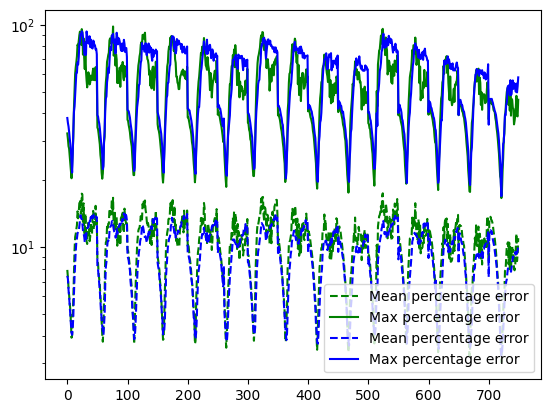

In [73]:
############# MAML TRAINING #############
# Construct empty tensor to store 
metalearner.model.eval()
y_pred = torch.tensor([]).to(device)
for X_batch, y_batch in test_loader:
    model.eval()
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = metalearner.model(X_batch, params=task_weights)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
ell_ape = np.mean(apes, axis=1)
maml_mape = np.mean(apes, axis=0)
maml_xape = np.max(apes, axis=0)
maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)
plt.plot(maml_mape, c='g', ls='--', label='Mean percentage error')
plt.plot(maml_xape, c='g', ls='-', label='Max percentage error')
plt.yscale('log')
plt.legend()

print('MAML MAPE:', np.mean(maml_mape))
print('MAML XAPE:', np.mean(maml_xape))
print('MAML Failure Rate:', maml_frate)

############# PRETRAINING #############
pretrain_model.eval()
y_pred = torch.tensor([]).to(device)
for X_batch, y_batch in test_loader:
    model.eval()
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = pretrain_model(X_batch)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
ell_ape = np.mean(apes, axis=1)
pretrain_mape = np.mean(apes, axis=0)
pretrain_xape = np.max(apes, axis=0)
pretrain_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)
plt.plot(pretrain_mape, c='b', ls='--', label='Mean percentage error')
plt.plot(pretrain_xape, c='b', ls='-', label='Max percentage error')
plt.yscale('log')
plt.legend()

print('Pretrain MAPE:', np.mean(pretrain_mape))
print('Pretrain XAPE:', np.mean(pretrain_xape))
print('Pretrain Failure Rate:', pretrain_frate)